In [23]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk import word_tokenize, pos_tag, FreqDist, SnowballStemmer
from nltk.corpus import wordnet as wn, stopwords
from gensim import corpora, models
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [6]:
# from dataProcessing.dataProcessing import userComments

In [11]:
userComments1 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (0-100k).csv')
userComments2 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (100-200k).csv')
userComments3 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (200-300k).csv')

userComments3['Unnamed: 0'] = userComments3['Unnamed: 0'].astype('float64')
userComments3['Userscore'] = userComments3['Userscore'].astype('float64')

userComments = pd.concat([userComments1, userComments2, userComments3], axis = 0)
userComments.drop(columns = 'Unnamed: 0', inplace = True)
userComments.dropna(how = 'all', inplace = True)

platformMap = {
'DS': 'DS',
'iOS': 'iOS',
'PC': 'PC',
'PlayStation': 'PS',
'PlayStation2': 'PS2',
'PlayStation3': 'PS3',
'PlayStation4': 'PS4',
'PlayStation5': 'PS5'
}

userComments['Platform_alignedNaming'] = userComments.Platform.map(platformMap)
userComments.loc[userComments.Platform_alignedNaming == 'not specified', 'Platform_alignedNaming'] = np.NaN

C:\Users\Michael\AppData\Local\Temp\ipykernel_3992\2076330302.py:1: DtypeWarning: Columns (1,2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  userComments1 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (0-100k).csv')
C:\Users\Michael\AppData\Local\Temp\ipykernel_3992\2076330302.py:2: DtypeWarning: Columns (1,2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  userComments2 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (100-200k).csv')


In [13]:
userComments_test = userComments.head().copy()

In [16]:
userComments_test

,Title,Platform,Userscore,Comment,Username,Platform_alignedNaming
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10.0,"Everything in OoT is so near at perfection, it...",SirCaestus,NaN
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10.0,I won't bore you with what everyone is already...,Kaistlin,NaN
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10.0,Anyone who gives the masterpiece below a 7 or ...,Jacody,NaN
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10.0,I'm one of those people who think that this is...,doodlerman,NaN
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10.0,This game is the highest rated game on Metacr...,StevenA,NaN


In [42]:
# # stop = stopwords.words('english')+[]

# # def wn(wnWord):
# #     ss = wn.synsets(wnWord)[0]
# #     hyps = list(set([w for s in ss.closure(lambda s:s.hyponyms())
# #                     for w in s.lemma_names()]))
# #     words_list = [w for w in hyps if "_" not in w]

# # def wc(series, stopwords):
# #     bodyParts_flat = [c for l in series for c in l]
# #     bodyParts_series_clean = [w for w in bodyParts_flat if w not in stopwords]
# #     bodyParts_series_clean = [t for t in bodyParts_series_clean
# #                               if not t.isnumeric()]
# #     fd_bodyParts= FreqDist(bodyParts_series_clean)
# #     wc_bodyParts = WordCloud(
# #                    background_color="white").generate_from_frequencies(fd_bodyParts)
# #     plt.imshow(wc_bodyParts, interpolation='bilinear')
# #     plt.axis("off")
# #     plt.show()
# #     return fd_bodyParts.most_common(20)

# def tagging_QA(df, colName, question = None, wnWord = None,
#                nounTagging = None, nounTagset = None, additionalStopWordsList = None):
    
#     wnl = nltk.WordNetLemmatizer()
    
#     if additionalStopWordsList == None:
#         stopwordsUsed = stopwords.words('english')
#     else:
#         stopwordsUsed = stopwords.words('english') + additionalStopWordsList
    
#     if wnWord != None:
#         ss = wn.synsets(wnWord)[0]
#         hyps = list(set([w for s in ss.closure(lambda s:s.hyponyms())
#                         for w in s.lemma_names()]))
#         wn_list = [w for w in hyps if "_" not in w]

#     if nounTagging == None and question != None:
#         qa = pipeline("question-answering")
#         for index, value in enumerate(df[colName]):
#             result = qa(question = question, context=value)
#             df.loc[df.index == index, 'Answer'] = result['answer']
#             print(f"Row {index} of {df.shape[0]} completed.")

#         df['Answer'] = df.Answer.apply(lambda x: list(set([wnl.lemmatize(w.lower())
#                                                         for w in word_tokenize(x)])))
#         if wnWord != None:
#             series = df.Answer.apply(lambda x: [noun for noun in x if noun in wn_list])
#         else:
#             series = df.Answer

#     if question == None and nounTagging != None:
#         noun_list = []
#         for value in df[colName]:

#             if nounTagset == 'universal':
#                 tagged_value = pos_tag(word_tokenize(value), tagset='universal')
#                 noun = list(set([wnl.lemmatize(word.lower()) for word, 
#                                 tag in tagged_value if tag == 'NOUN']))
#             else:
#                 tagged_value = pos_tag(word_tokenize(value))
#                 noun = list(set([wnl.lemmatize(word.lower()) for word,
#                                 tag in tagged_value if tag == 'NN' or tag == 'NNS']))
            
#             noun_list.append(noun)
#         df['Text_NounOnly'] = noun_list

#         if wnWord != None:
#             series = df.Text_NounOnly.apply(lambda x: [noun for noun in x if noun in wn_list])
#         else:
#             series = df.Text_NounOnly
            
#     if question == None and nounTagging == None:
#         series = df[colName].apply(lambda x: list(set([wnl.lemmatize(w.lower())
#                                                         for w in word_tokenize(x)])))

#     # Bring all lemmatization down!!
#     bodyParts_flat = [c for l in series for c in l]
#     bodyParts_series_clean = [w for w in bodyParts_flat if w not in stopwordsUsed]
#     bodyParts_series_clean = [t for t in bodyParts_series_clean if t not in string.punctuation]
#     bodyParts_series_clean = [t for t in bodyParts_series_clean if not t.isnumeric()]
#     fd_bodyParts= FreqDist(bodyParts_series_clean)
#     wc_bodyParts = WordCloud(background_color="white").generate_from_frequencies(fd_bodyParts)
#     plt.imshow(wc_bodyParts, interpolation='bilinear')
#     plt.axis("off")
#     plt.show()
    
#     return fd_bodyParts.most_common(10)

In [53]:
def tagging_QA(df, colName, wnWord = None, nounTaggingBoolean = None, nounTagset = None, question = None, additionalStopWordsList = None):
    
    wnl = nltk.WordNetLemmatizer()
    
    if additionalStopWordsList == None:
        stopwordsUsed = stopwords.words('english')
    else:
        stopwordsUsed = stopwords.words('english') + additionalStopWordsList
    
    if wnWord != None:
        ss = wn.synsets(wnWord)[0]
        hyps = list(set([w for s in ss.closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))
        wn_list = [w for w in hyps if "_" not in w]

    if nounTaggingBoolean == None and question != None:
        qa = pipeline("question-answering")
        for index, value in enumerate(df[colName]):
            result = qa(question = question, context=value)
            df.loc[df.index == index, 'Answer'] = result['answer']
            print(f"Row {index} of {df.shape[0]} completed.")

        df['Answer'] = df.Answer.apply(lambda x: list(set([w.lower() for w in word_tokenize(x)]))) # consider bi-gram
        if wnWord != None:
            series = df.Answer.apply(lambda x: [noun for noun in x if noun in wn_list])
        else:
            series = df.Answer

    if question == None and nounTaggingBoolean != None:
        noun_list = []
        for value in df[colName]:

            if nounTagset == 'universal':
                tagged_value = pos_tag(word_tokenize(value), tagset='universal')
                noun = list(set([word.lower() for word, tag in tagged_value if tag == 'NOUN']))
            else:
                tagged_value = pos_tag(word_tokenize(value))
                noun = list(set([word.lower() for word, tag in tagged_value if tag == 'NN' or tag == 'NNS']))
            
            noun_list.append(noun)
        df['Text_NounOnly'] = noun_list

        if wnWord != None:
            series = df.Text_NounOnly.apply(lambda x: [noun for noun in x if noun in wn_list])
        else:
            series = df.Text_NounOnly
            
    if question == None and nounTaggingBoolean == None:
        series = df[colName].apply(lambda x: list(set([w.lower() for w in word_tokenize(x)])))

    bodyParts_flat = [c for l in series for c in l]
    bodyParts_series_clean = [w for w in bodyParts_flat if w not in stopwordsUsed]
    bodyParts_series_clean = [t for t in bodyParts_series_clean if t not in string.punctuation]
    bodyParts_series_clean = [t for t in bodyParts_series_clean if not t.isnumeric()]
    bodyParts_series_clean = [wnl.lemmatize(w) for w in bodyParts_series_clean]
    fd_bodyParts= FreqDist(bodyParts_series_clean)
    wc_bodyParts = WordCloud(background_color="white").generate_from_frequencies(fd_bodyParts)
    plt.imshow(wc_bodyParts, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    return fd_bodyParts.most_common(10)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\Michael\AppData\Local\Temp\ipykernel_3992\2240976669.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df.index == index, 'Answer'] = result['answer']
C:\Users\Michael\AppData\Local\Temp\ipykernel_3992\2240976669.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'its really no wonder that this game has such a huge fanbase' has dtype incompatible with float64, please explicitly cast to a compatible dtype f

Row 0 of 50 completed.
Row 1 of 50 completed.
Row 2 of 50 completed.
Row 3 of 50 completed.
Row 4 of 50 completed.
Row 5 of 50 completed.
Row 6 of 50 completed.
Row 7 of 50 completed.
Row 8 of 50 completed.
Row 9 of 50 completed.
Row 10 of 50 completed.
Row 11 of 50 completed.
Row 12 of 50 completed.
Row 13 of 50 completed.
Row 14 of 50 completed.
Row 15 of 50 completed.
Row 16 of 50 completed.
Row 17 of 50 completed.
Row 18 of 50 completed.
Row 19 of 50 completed.
Row 20 of 50 completed.
Row 21 of 50 completed.
Row 22 of 50 completed.
Row 23 of 50 completed.
Row 24 of 50 completed.
Row 25 of 50 completed.
Row 26 of 50 completed.
Row 27 of 50 completed.
Row 28 of 50 completed.
Row 29 of 50 completed.
Row 30 of 50 completed.
Row 31 of 50 completed.
Row 32 of 50 completed.
Row 33 of 50 completed.
Row 34 of 50 completed.
Row 35 of 50 completed.
Row 36 of 50 completed.
Row 37 of 50 completed.
Row 38 of 50 completed.
Row 39 of 50 completed.
Row 40 of 50 completed.
Row 41 of 50 completed.
Ro

C:\Users\Michael\AppData\Local\Temp\ipykernel_3992\2240976669.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Answer'] = df.Answer.apply(lambda x: list(set([w.lower() for w in word_tokenize(x)])))


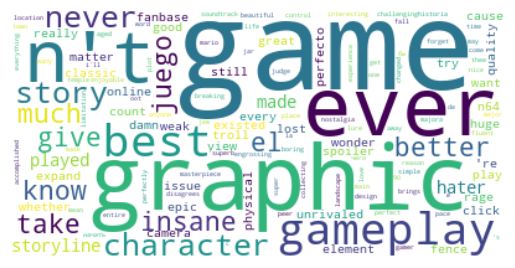

[('game', 11),
 ('graphic', 5),
 ('ever', 4),
 ("n't", 3),
 ('gameplay', 3),
 ('best', 3),
 ('character', 3),
 ('story', 3),
 ('never', 3),
 ('give', 2)]

In [49]:
# tagging_QA(df, colName, question = None, wnWord = None,
#                nounTagging = None, nounTagset = None, additionalStopWordsList = None)

tagging_QA(userComments.head(50), 'Comment', question = "What are the main problems in the game?")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\Michael\AppData\Local\Temp\ipykernel_3992\2240976669.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df.index == index, 'Answer'] = result['answer']
C:\Users\Michael\AppData\Local\Temp\ipykernel_3992\2240976669.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'this game has such a huge fanbase' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df.index ==

Row 0 of 50 completed.
Row 1 of 50 completed.
Row 2 of 50 completed.
Row 3 of 50 completed.
Row 4 of 50 completed.
Row 5 of 50 completed.
Row 6 of 50 completed.
Row 7 of 50 completed.
Row 8 of 50 completed.
Row 9 of 50 completed.
Row 10 of 50 completed.
Row 11 of 50 completed.
Row 12 of 50 completed.
Row 13 of 50 completed.
Row 14 of 50 completed.
Row 15 of 50 completed.
Row 16 of 50 completed.
Row 17 of 50 completed.
Row 18 of 50 completed.
Row 19 of 50 completed.
Row 20 of 50 completed.
Row 21 of 50 completed.
Row 22 of 50 completed.
Row 23 of 50 completed.
Row 24 of 50 completed.
Row 25 of 50 completed.
Row 26 of 50 completed.
Row 27 of 50 completed.
Row 28 of 50 completed.
Row 29 of 50 completed.
Row 30 of 50 completed.
Row 31 of 50 completed.
Row 32 of 50 completed.
Row 33 of 50 completed.
Row 34 of 50 completed.
Row 35 of 50 completed.
Row 36 of 50 completed.
Row 37 of 50 completed.
Row 38 of 50 completed.
Row 39 of 50 completed.
Row 40 of 50 completed.
Row 41 of 50 completed.
Ro

C:\Users\Michael\AppData\Local\Temp\ipykernel_3992\2240976669.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Answer'] = df.Answer.apply(lambda x: list(set([w.lower() for w in word_tokenize(x)])))


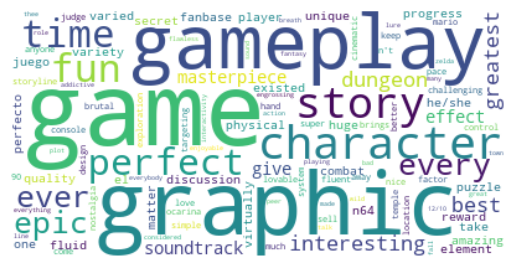

[('game', 10),
 ('graphic', 7),
 ('gameplay', 5),
 ('character', 4),
 ('story', 4),
 ('fun', 3),
 ('time', 3),
 ('perfect', 3),
 ('ever', 2),
 ('every', 2)]

In [50]:
tagging_QA(userComments.head(50), 'Comment', question = "What are the best features of the game?")

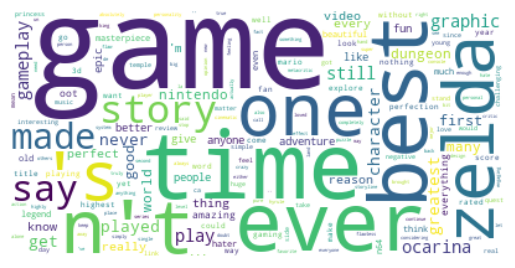

[('game', 70),
 ('time', 33),
 ('best', 24),
 ('ever', 24),
 ("n't", 20),
 ('one', 19),
 ('zelda', 18),
 ("'s", 17),
 ('story', 16),
 ('say', 14)]

In [51]:
tagging_QA(userComments.head(50), 'Comment')

In [39]:
# qa("What are the key features in the game?", userComments_test, 'Comment')

In [24]:
userComments_test.Answer

0                                                      huge fanbase
1                                                       how amazing
2       the combat is varied, fluid, and fun, the items are amazing
3      no matter what quality games are out now or will be out ever
4    It takes elements from every other game that existed before it
Name: Answer, dtype: object

In [ ]:
df['Answer'] = df.Answer.apply(lambda x: list(set([wnl.lemmatize(w.lower()) for w in word_tokenize(x)])))
bodyPartsQnA_series = df.Answer.apply(lambda x: [noun for noun in x if noun in bodyParts_list])

In [ ]:
wc(bodyPartsQnA_series, stop)

In [ ]:
pacman::p_load(tidyverse, mice, DMwR, car, caret, ROCR,naniar, caTools)


#####################################################
# set path to folder where raw data is kept
# pay attention to the '/'
setwd("C:/Users/Michael/OneDrive/Documents/MTech/MTech EBAC/GC - Business Analytics Practice/Predictive Analytics - Insights of Trends & Irregularities/Day 2/AM/data and code")

#####################################################
# read the data file & inspect it's structure
data = read.csv('risk_factors_cervical_cancer.csv', 
                na.strings = c('?')) # convert '?' into NA

# str(data)
# 858 obs. 36 vars.

data = data %>%
       dplyr::select(Age, Number.of.sexual.partners, First.sexual.intercourse,
  Num.of.pregnancies, Smokes, Smokes..years., Hormonal.Contraceptives, Hormonal.Contraceptives..years.,
  IUD, IUD..years., STDs..number., 
  STDs..Time.since.last.diagnosis, Biopsy)

str(data)

cols_ft = c('Smokes', 'Hormonal.Contraceptives', 'IUD', 'Biopsy')
data[, cols_ft] = lapply(data[, cols_ft], factor)

summary(data)

colMeans(is.na(data))

##################################################
### remove the columns with high % of missings
# STDs..Time.since.last.diagnosis with 91 % missing
data$STDs..Time.since.last.diagnosis = NULL

corrplot::corrplot(cor(data[, sapply(data, is.numeric)],
                       use="complete.obs"), method = "number", type='lower')


###################################################
# impute missing data

cancer_imput= mice(data[, !names(data) %in% "Biopsy"])  # NEVER INPUTE WITH TARGET VAR INSIDE!! (hence need take out, else will end up predicting it)
# we can also provide method = ?

cancer = complete(cancer_imput) # taking the first dataset


cancer$Target = data$Biopsy

summary(cancer)

colMeans(is.na(cancer))
head(cancer)

prop.table(table(cancer$Target))
# only 6 % cancer [check if balanced/ imbalanced -- it is imbalanced!]

#set initial seed
set.seed(123)

In [ ]:
# CREATE TRAIN TEST SPLIT


# create a boolean flag to split data
splitData = sample.split(cancer$Target, SplitRatio = 0.85)

#split_data
# create train and test datasets
train_set = cancer[splitData,]

nrow(train_set)/nrow(cancer)

test_set = cancer[!splitData,]
nrow(test_set)/nrow(cancer)

dim(train_set)
table(train_set$Target)
prop.table(table(train_set$Target))

In [ ]:
# VIF AND STEPWISE REG

# use train to create our 1st model
# use all independent variables 
model = glm(Target ~ ., data = train_set, family = binomial)
summary(model)

# check for multi-collinearity
vif(model)

model = step(model, trace = F)

summary(model)

In [ ]:
# TEST ON TRAIN DF

# test it on the train set
trainPredict = predict(model, newdata = train_set, 
                       type = 'response')

# assign 0s or 1s for the values [coz imbalanced, if put 0.5 it may not even have a predicted col in confusion matrix!!!]
p_class = ifelse(trainPredict > 0.2, 1,0)

In [ ]:
# EVALUATION

matrix_table = table(train_set$Target, p_class)
matrix_table

confusionMatrix(table(p_class,train_set$Target), positive='1')

In [ ]:
# SMOTE FOR IMBALANCED

train_set$Target = as.factor(train_set$Target)
table(train_set$Target)
#set initial seed
set.seed(123)
train_sm = SMOTE(Target ~ . ,  train_set, 
                 perc.over = 300, # to synthesise additonal 300% of the minority class (excluding the existing amount)!
                 perc.under = 100) # for every new case i create, take 1 case from the majority! (and then use this binary distribution for modelling instead!!)
# try different perc.over  perc.under 
table(train_sm$Target)
dim(train_sm)

prop.table(table(train_sm$Target))

str(train_sm)

In [ ]:
# VIF AND STEPWISE REG (AFTER FIXING IMBALANCED)

# use all independent variables 
model2 = glm(Target ~ ., data = train_sm, family = binomial)

# check for multicollinearity
vif(model2)
summary(model2)

model2 = step(model2, trace = F)

summary(model2)

In [ ]:
# TEST ON TRAIN DF (AFTER FIXING IMBALANCED)

# test it on the train set
trainPredict = predict(model2, newdata = train_sm, 
                       type = 'response')

# assign 0s or 1s for the values
p_class = ifelse(trainPredict > 0.5, 1,0)

In [ ]:
# EVALUATION (AFTER FIXING IMBALANCED)

matrix_table = table(train_sm$Target, p_class)
matrix_table

confusionMatrix(table(p_class,train_sm$Target), positive='1')
                
table(test_set$Target)

In [ ]:
# test it on the test set
testPredict = predict(model2, newdata = test_set, 
                      type = 'response')
p_class2 = ifelse(testPredict > 0.5, 1,0)

matrix_table = table(test_set$Target, p_class2)
matrix_table

# 12/(12+5)# Recall/True Positive Rate/Sensitivity
# 
# 12/(12+179) #pos pred rate or Precision/Hit Rate 

# Prevalence: How often does 1  occur in our total data?
# (5+12)/sum(matrix_table) # prevalence

confusionMatrix(table(p_class2,test_set$Target), positive='1')

In [ ]:
# ROC Curve
# we can examine many cut-offs visually
# auc: area under the curve
# can be used to compare multiple models drawn on the same chart
pred = prediction( trainPredict, train_set$subscribed )

perf = performance( pred, "tpr", "fpr" )

plot( perf, colorize = TRUE,
      print.cutoffs.at = seq(0,1,0.1), 
      text.adj = c(-0.2, 1.7))

abline(a=0, b=1)

# perf2 = performance( pred, "acc" ) # overall accuraacy
# plot(perf2)

#AUC
pROC::auc(train_set$subscribed, trainPredict)

#############################################################
# Cost based analysis
# when business knows the relative cost of fp or fn
# e.g. let us say the fp are 4 times as costly as fn in a business
cost.perf = performance(pred, "cost", cost.fp = 4, cost.fn = 1)
pred@cutoffs[[1]][which.min(cost.perf@y.values[[1]])]

# cost.perf = performance(pred, "cost")
# pred@cutoffs[[1]][which.min(cost.perf@y.values[[1]])]

# area under the curve
# can be used to compare multiple models drawn on the same chart
auc_measure = performance( pred, "auc" )
unlist(slot(auc_measure, 'y.values'))

In [ ]:
# Create a lift chart
pred = prediction( trainPredict, train_set$subscribed )

perf = performance(pred, "lift", "rpp" )

plot(perf, main="lift curve", 
     xlab = 'Proportion of Customers (sorted prob)')

## lift curve with customer deciles as x axis
# 
# lift <- function(target, prob, groups=10) {
# if(is.factor(target)) target = as.integer(as.character(target))
# if(is.factor(prob)) prob <- as.integer(as.character(prob))
# table = data.frame(cbind(target, prob))
# table[,"decile"] = ntile(-table[,"prob"], groups)
# gaintable = table %>% group_by(decile)  %>%
#   summarise_at(vars(target), funs(total = n(),
#   totalresp=sum(., na.rm = TRUE))) %>%
#   mutate(
#       Cumresp = cumsum(totalresp), 
#       decile_response = (totalresp/total)*100,       
#       gain=Cumresp/sum(totalresp)*100,
#       lift=gain/(decile*(100/groups)),
#       overall_resp = sum(totalresp),
#       total_repondent_examined = sum(total))
# return(gaintable)
# }
# 
# (df = lift(train_set$subscribed , trainPredict, groups = 10))
# 
# plot(df$decile, df$lift, type="l", ylab="cum. lift", xlab="decile")